<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


## Mount Google Drive to Colab Environment

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## EDA Functions

In [5]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [6]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [7]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [8]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [9]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test
* Imported 50000 labels for training and 10000 labels for test

In [11]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels

In [12]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [13]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [14]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

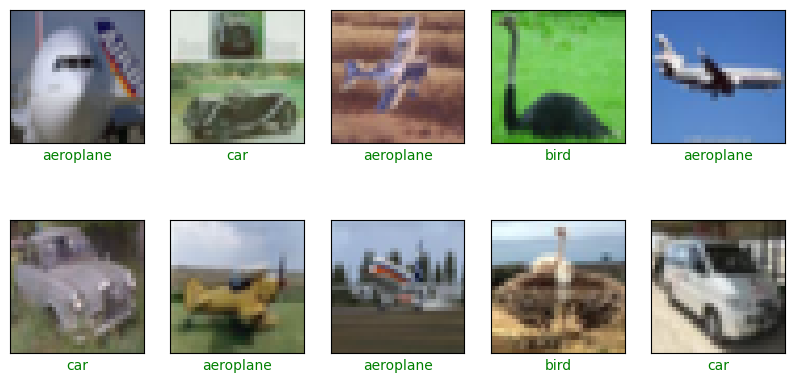

In [15]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [16]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [17]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [18]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255


1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [19]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/CNN_architecture_v4.png?raw=1">


## Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [20]:
k.clear_session()
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

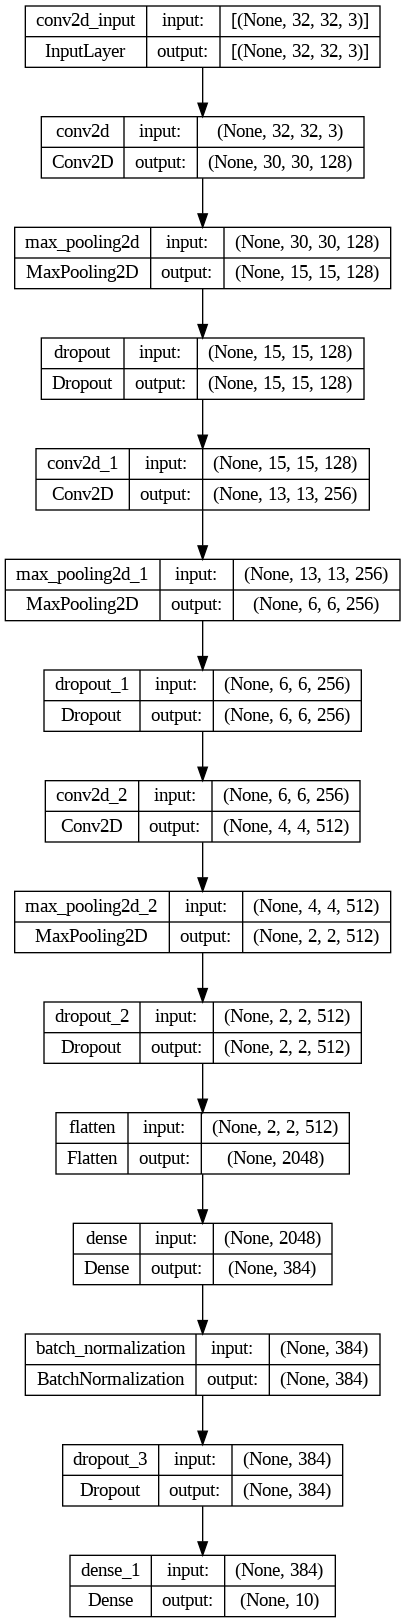

In [22]:
tf.keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True)

## Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [24]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/200
704/704 [==============================] - 19s 14ms/step - loss: 1.6844 - accuracy: 0.4177 - val_loss: 1.5625 - val_accuracy: 0.4628
Epoch 2/200
  5/704 [..............................] - ETA: 9s - loss: 1.4246 - accuracy: 0.5281 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 9s 13ms/step - loss: 1.3176 - accuracy: 0.5650 - val_loss: 1.1760 - val_accuracy: 0.6052
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1785 - accuracy: 0.6239 - val_loss: 1.0746 - val_accuracy: 0.6458
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0939 - accuracy: 0.6581 - val_loss: 1.0562 - val_accuracy: 0.6656
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0194 - accuracy: 0.6823 - val_loss: 0.9004 - val_accuracy: 0.7140
Epoch 6/200
704/704 [==============================] - 10s 14ms/step - loss: 0.9685 - accuracy: 0.7048 - val_loss: 0.8880 - val_accuracy: 0.7260
Epoch 7/200
704/704 [==============================] - 10s 14ms/step - loss: 0.9194 - accuracy: 0.7242 - val_loss: 0.8662 - val_accuracy: 0.7318
Epoch 8/200
704/704 [==============================] - 11s 16ms/step - loss: 0.8954 - accuracy: 0.7308 - val_loss: 0.8317 - val_accuracy: 0.7548
E

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [25]:
model = tf.keras.models.load_model("CNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.7902 - accuracy: 0.7654
Test acc: 0.765


## Predictions

In [26]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,0.838,0.752,0.850,0.753
10,0.807,0.762,0.770,0.771
11,0.790,0.769,0.798,0.758
12,0.769,0.779,0.799,0.764
13,0.757,0.782,0.821,0.757


## Plot Training Metrics (Loss and Accuracy)

<ipython-input-7-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


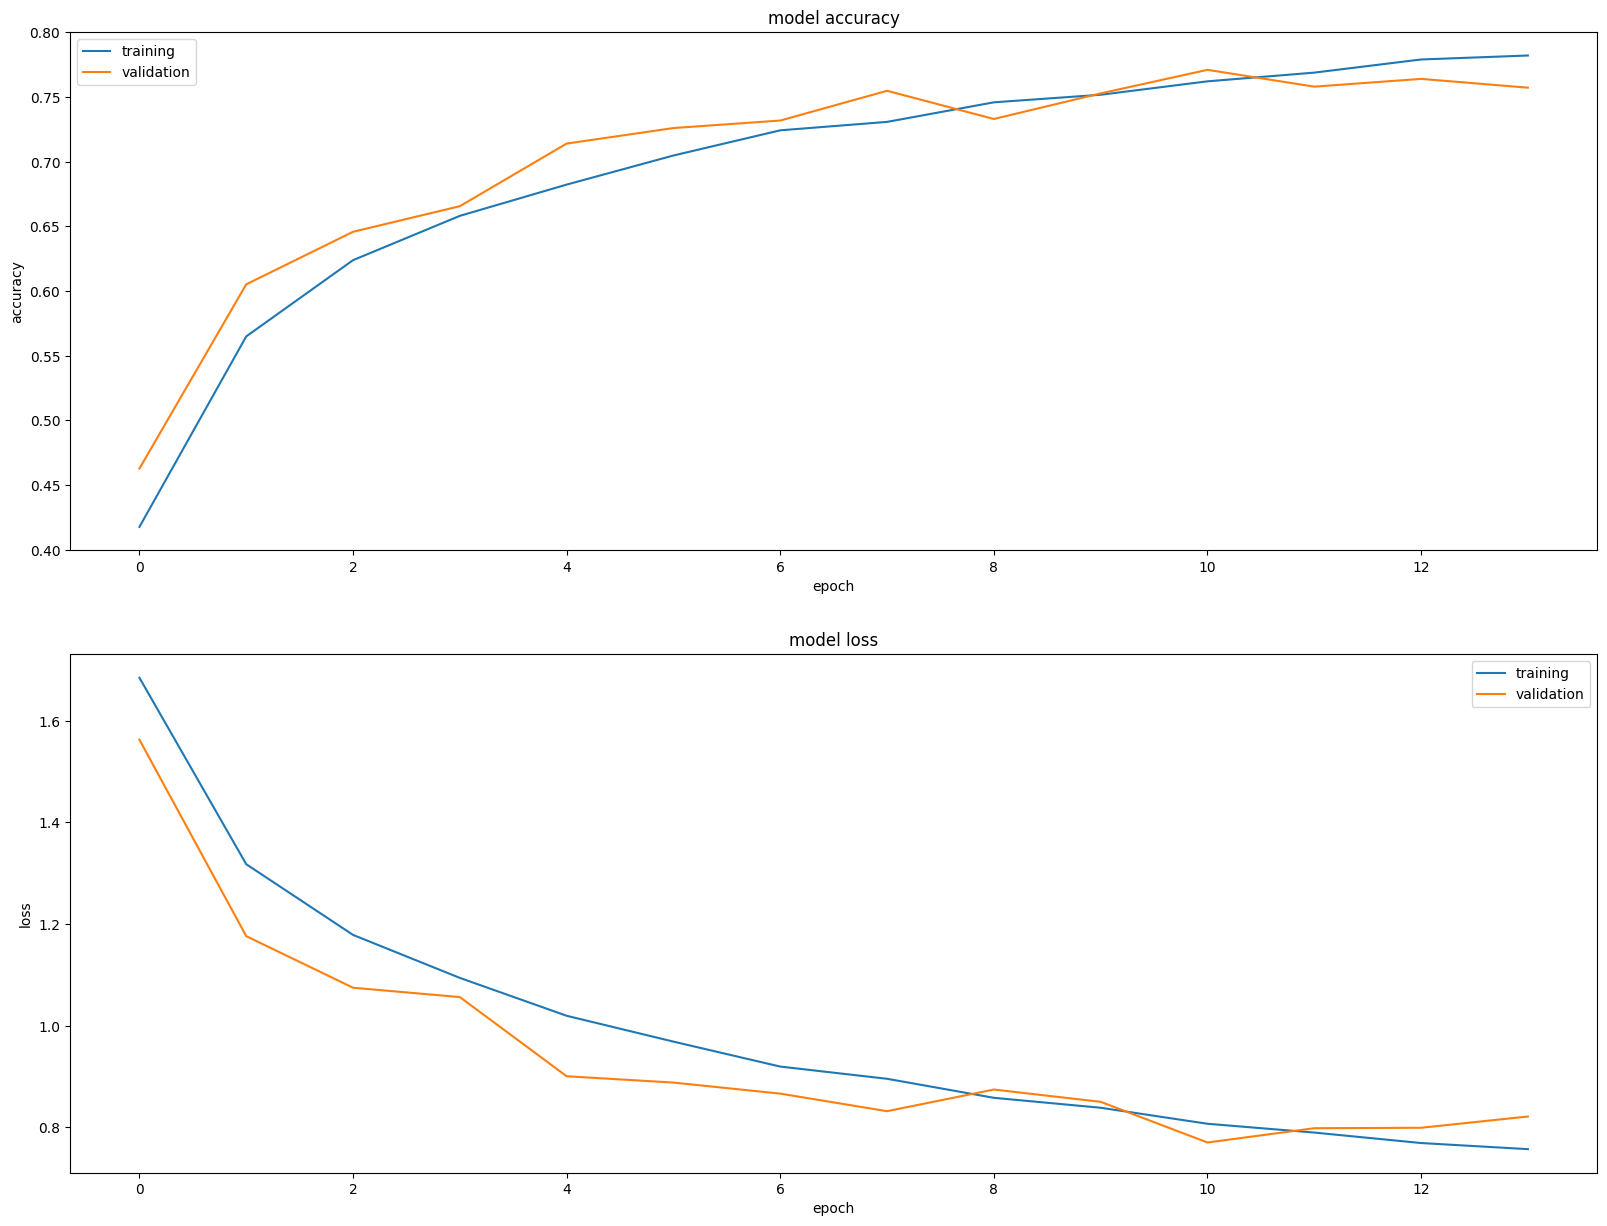

In [29]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [30]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [31]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.89      0.91      0.90      1000
           2       0.74      0.61      0.67      1000
           3       0.56      0.56      0.56      1000
           4       0.77      0.66      0.71      1000
           5       0.58      0.77      0.66      1000
           6       0.81      0.85      0.83      1000
           7       0.83      0.77      0.80      1000
           8       0.88      0.87      0.87      1000
           9       0.90      0.81      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy Score: 0.7654
Root Mean Square Error: 1.91449732305898


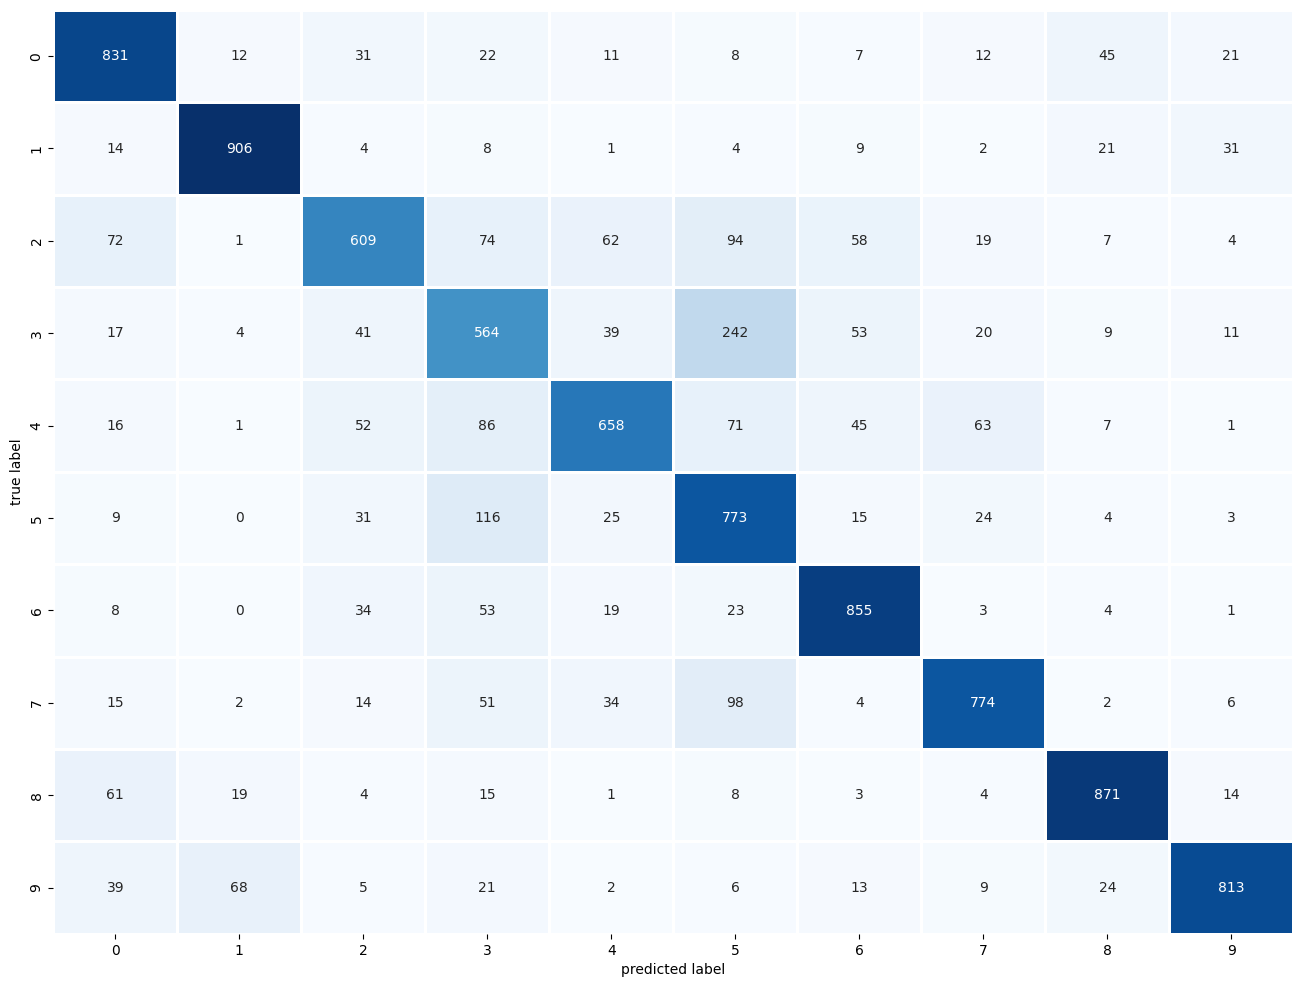

In [32]:
plot_confusion_matrix(y_test,pred1)

## Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [33]:
model = tf.keras.models.load_model('CNN_model.h5')

In [34]:
preds = model.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [35]:
preds.shape

(10000, 10)

## Predictions

In [36]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [37]:
df = pd.DataFrame(preds[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,6.48%,0.49%,3.68%,53.41%,0.21%,26.78%,3.11%,1.25%,3.92%,0.68%
1,0.65%,69.80%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,29.45%,0.10%
2,8.59%,7.91%,0.27%,0.85%,0.17%,0.26%,0.29%,0.28%,79.04%,2.33%
3,91.50%,1.50%,1.39%,0.32%,0.20%,0.09%,0.03%,0.11%,4.03%,0.82%
4,0.00%,0.00%,0.59%,0.37%,10.33%,0.12%,88.59%,0.01%,0.00%,0.00%
5,0.00%,0.02%,0.15%,0.85%,0.07%,2.14%,96.70%,0.05%,0.00%,0.01%
6,0.14%,97.16%,0.44%,0.39%,0.00%,0.29%,0.22%,0.08%,0.03%,1.25%
7,1.19%,0.23%,21.36%,15.19%,10.20%,3.49%,46.59%,1.07%,0.40%,0.27%
8,0.12%,0.02%,1.53%,64.95%,2.28%,28.34%,0.54%,2.12%,0.03%,0.07%
9,0.69%,96.94%,0.05%,0.03%,0.01%,0.01%,0.06%,0.01%,0.28%,1.92%


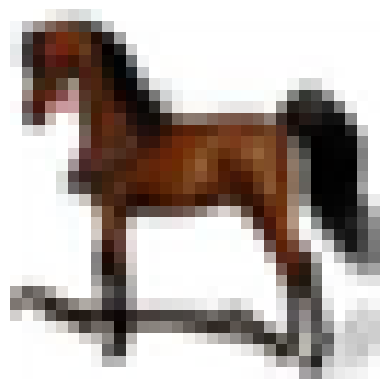

In [38]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [39]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [40]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 362ms/step


8

In [41]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1']

<ipython-input-42-1efdfb529874>:28: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


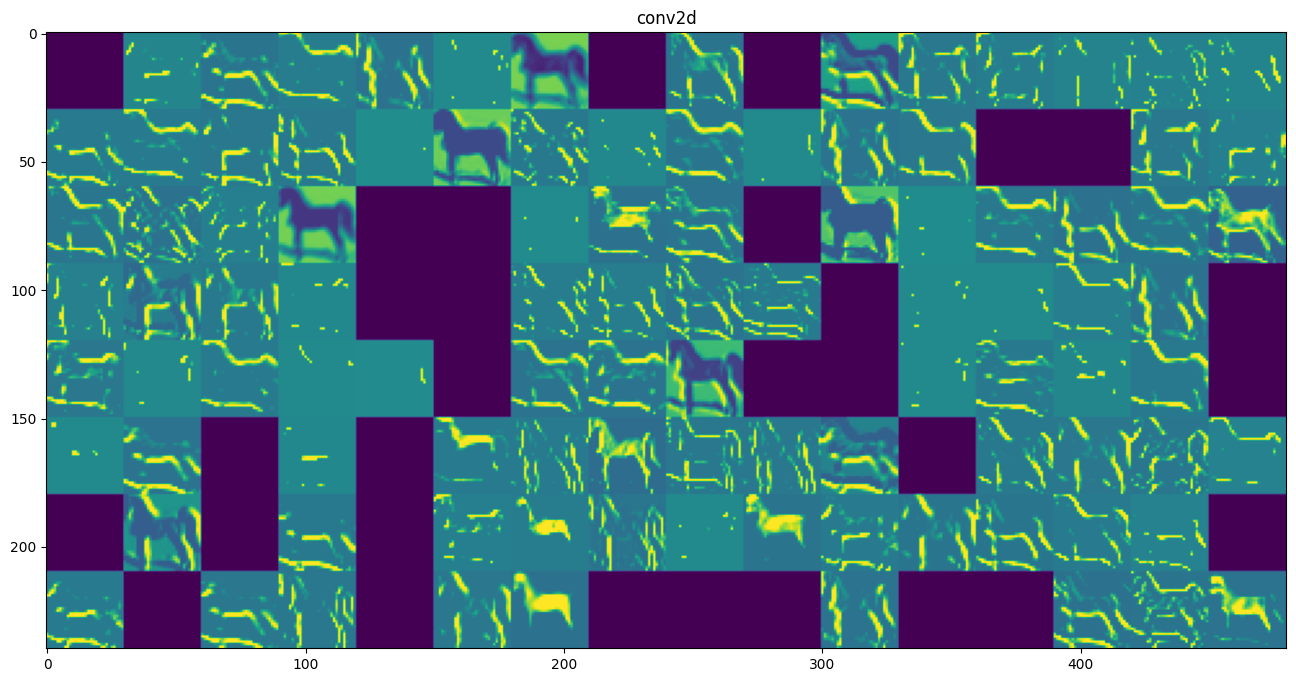

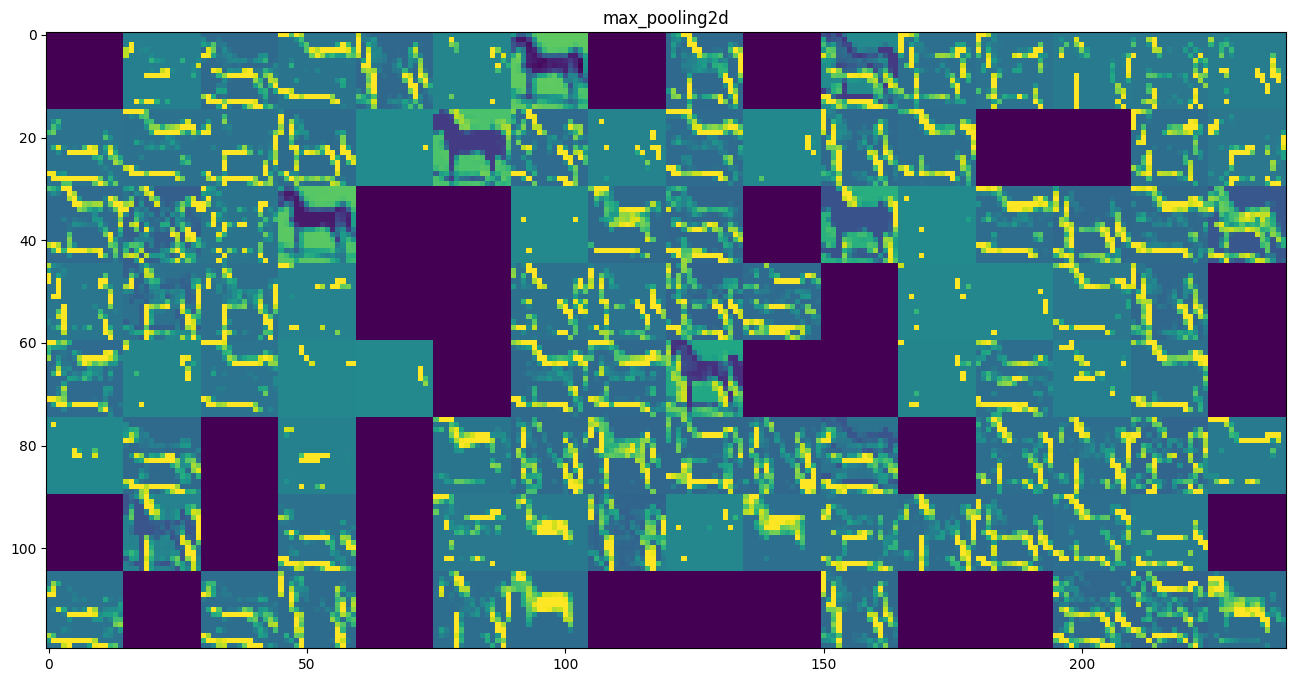

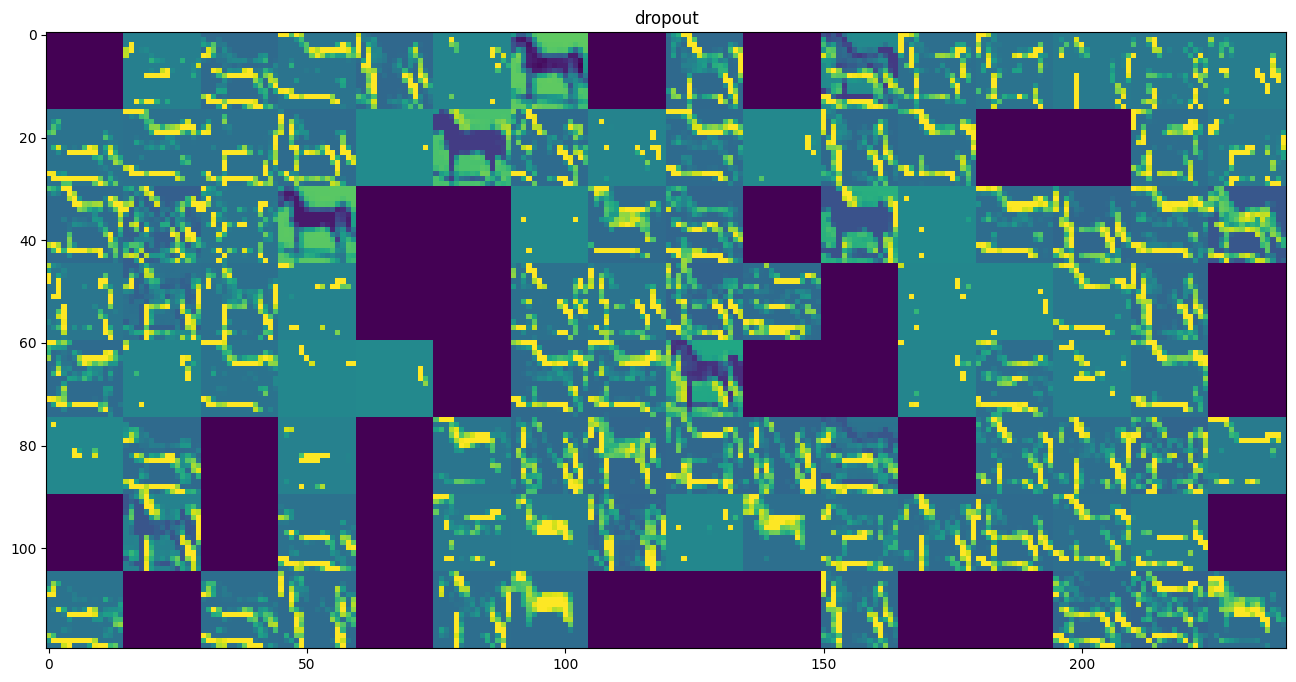

In [42]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();